In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41356 instead
  warnings.warn(


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import gcm_filters
import xrft
from dask.diagnostics import ProgressBar
from rechunker import rechunk
import zarr

In [14]:
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_smoothed.zarr')
eta_merged = eta_merged.isel(time=slice(1,1800))

In [15]:
eta_28 = eta_merged.isel(time=slice(0,2000,3))

In [16]:
#write to zarr so we can rechunk into time
eta_28.to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28_smoothed.zarr')

# Rechunk in time so that tide fitting is easier

In [17]:
source = zarr.open('/swot/SUM02/spencer/swot_agulhas_surf/eta_28_smoothed.zarr')
intermediate = "/swot/SUM02/spencer/swot_agulhas_surf/intermediate.zarr"
target = "/swot/SUM02/spencer/swot_agulhas_surf/eta_28times.zarr"

In [18]:
target_chunks = {
    'eta': {'time':584,'j':180,'i':180},
    'x': {'i':180, 'j':180},
    'y': {'i':180, 'j':180},
    'time': None, # don't rechunk this array
    'iter': None,
    'i': None,
    'j': None,
}

In [19]:
rechunked = rechunk(source, target_chunks=target_chunks,target_store=target,max_mem='800MB',temp_store=intermediate)

In [20]:
rechunked.execute();

_copy_chunk((slice(0, 21, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(21, 42, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(42, 63, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(63, 84, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(84, 105, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(105, 126, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(126, 147, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(147, 168, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(168, 189, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(189, 210, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(210, 231, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(231, 252, None), slice(0, 2160, None), slice(0, 2160, None)))
_copy_chunk((slice(252, 273, None), sl

In [22]:
eta_28 = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_28times.zarr")
eta_28 = eta_28.assign_coords({'time':eta_28.time/10**9/3600})
eta_detrend = eta_28.eta - eta_28.eta.rolling(time=24).mean()
eta_detrend.to_dataset(name='eta').to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28detrends.zarr')

In [165]:
eta_28 = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_28times.zarr")

<xarray.DataArray 'time' (time: 584)>
array([  72,   75,   78, ..., 1815, 1818, 1821], dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00.000000072 ... 00:00:00.000001821

# Start here to restart

In [8]:
eta_detrend = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28detrends.zarr').eta

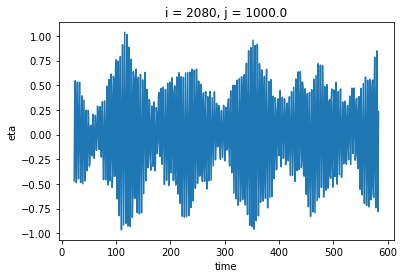

In [4]:
eta_detrend.isel(i=1000,j=1000).plot()

In [11]:
m2=12.4206012/3
s2=12/3
n2=12.65834751/3
k2=11.96723606/3
k1=23.93447213/3
o1=25.81933871/3
q1=26.868350/3
p1=24.06588766/3
#o1 is still really hard to fit in many locations. p1 too and it's very small. I have also stopped fitting k2 because it's too close to s2

def sinusoid_check(time, a=0.004,b=0.5,c=1.3,d=0.1,e=4,f=0.1,g=0.1,h=0.1,k=0.1,l=0.1,m=0.1,n=0.1,o=0.1):#,p=0.1,q=0.1,r=0.1,s=0.1):#):#,h=0.1,k=0.1,r=0.1,s=0.1):
    return (a+b*np.sin(time*2*np.pi/m2+c)+d*np.sin(time*2*np.pi/s2+e)+f*np.sin(time*2*np.pi/k1+g)+h*np.sin(time*2*np.pi/o1+k)
       + l*np.sin(time*2*np.pi/n2+m)+n*np.sin(time*2*np.pi/k2+o))#+p*np.sin(time*2*np.pi/q1+q))#+r*np.sin(time*2*np.pi/p1+s))


In [6]:
check_it = (eta_detrend).chunk({'time': -1}).isel(i=slice(500,1000),j=1000,time=slice(18,2000)).curvefit('time',sinusoid_check,skipna=False,
                                                                              bounds={"b": (0, 2),"d": (0, 2),"f": (0, 1),"h": (0, 1),"l": (0, 1),"n": (0, 1),"p": (0, 1),"r": (0, 1)})


In [ ]:
for ii in range(0,216):
    print(ii)
    test_curvefit = eta_detrend.chunk({'time':-1}).isel(i=slice(ii*10,ii*10+10),time=slice(24,-24)).curvefit('time',sinusoid_check,
                                                                              bounds={"b": (0, 2),"d": (0, 2),"f": (0, 1),"h": (0, 1),"l": (0, 1),"n": (0, 1)})#,"p": (0, 1),"r": (0, 1)})#,"o": (0, 2*np.pi),"k": (0, 2*np.pi)
    test_curvefit.curvefit_coefficients.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_28.zarr',append_dim='i')

0
1
2
3
4
5


In [2]:
coeffs = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_28.zarr').isel(i=slice(10,2170))

In [3]:
coeffs.param

<xarray.DataArray 'param' (param: 13)>
array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o'],
      dtype='<U1')
Coordinates:
  * param    (param) <U1 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'k' 'l' 'm' 'n' 'o'

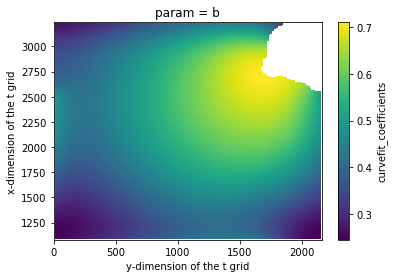

In [4]:
coeffs.curvefit_coefficients.sel(param='b').plot()

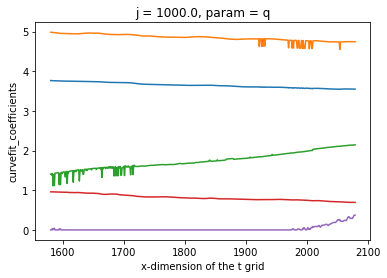

In [31]:
check_it.curvefit_coefficients.sel(param='c').plot()
check_it.curvefit_coefficients.sel(param='e').plot()
check_it.curvefit_coefficients.sel(param='g').plot()
#check_it.curvefit_coefficients.sel(param='k').plot()
check_it.curvefit_coefficients.sel(param='m').plot()
#check_it.curvefit_coefficients.sel(param='o').plot()
check_it.curvefit_coefficients.sel(param='q').plot()
#check_it.curvefit_coefficients.sel(param='s').plot()

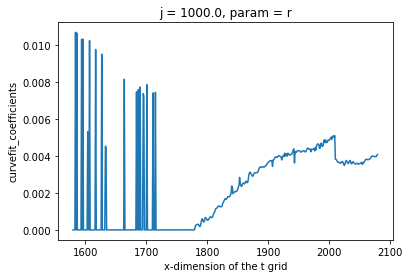

In [35]:
check_it.curvefit_coefficients.sel(param='r').plot()

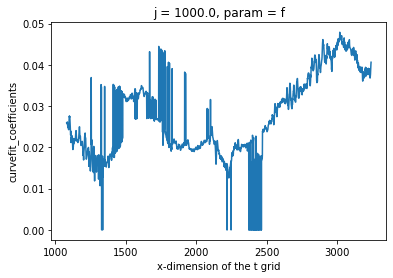

In [89]:
check_it.curvefit_coefficients.sel(param='o').plot()

In [9]:
new_object=xr.DataArray(np.arange(0, 584),dims=['time'])
new_object = new_object*xr.ones_like(eta_detrend)

In [14]:
tide_est = xr.apply_ufunc(sinusoid_check,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d'),
              coeffs.curvefit_coefficients.sel(param='e'),coeffs.curvefit_coefficients.sel(param='f'),
              coeffs.curvefit_coefficients.sel(param='g'),coeffs.curvefit_coefficients.sel(param='h'),
              coeffs.curvefit_coefficients.sel(param='k'),
                          coeffs.curvefit_coefficients.sel(param='l'),
              coeffs.curvefit_coefficients.sel(param='m'),coeffs.curvefit_coefficients.sel(param='n'),
                        coeffs.curvefit_coefficients.sel(param='o'),#check_it.curvefit_coefficients.sel(param='p'),
                      #  check_it.curvefit_coefficients.sel(param='q'),check_it.curvefit_coefficients.sel(param='r'),
                      #  check_it.curvefit_coefficients.sel(param='s')
            dask='allowed')

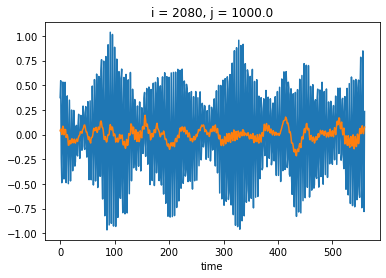

In [15]:
eta_detrend.isel(i=1000,j=1000,time=slice(24,1000)).plot()
(eta_detrend.isel(i=1000,j=1000,time=slice(24,1000))-tide_est.isel(i=1000,j=1000,time=slice(0,-24))).plot()
#tide_est.isel(i=1000,j=1000,time=slice(0,1000)).plot()

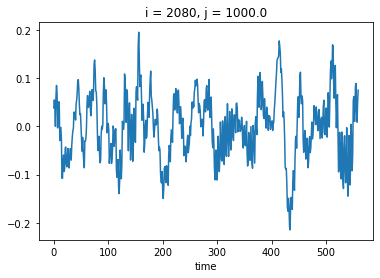

In [16]:
(eta_detrend.isel(i=1000,j=1000,time=slice(24,1000))-tide_est.isel(i=1000,j=1000,time=slice(0,-24))).plot()

In [17]:
eta_28 = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_28time.zarr")

In [97]:
eta_28.time

<xarray.DataArray 'time' (time: 584)>
array([ 259200000000000,  270000000000000,  280800000000000, ...,
       6534000000000000, 6544800000000000, 6555600000000000],
      dtype='timedelta64[ns]')
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3 days 00:00:00 ... 75 days 21:00:00
Attributes:
    axis:           T
    calendar:       gregorian
    long_name:      Time
    standard_name:  time

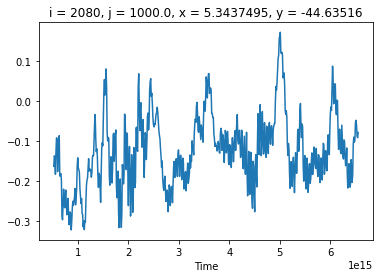

In [18]:
(eta_28.Eta.isel(i=1000,j=1000,time=slice(24,1000))-tide_est.isel(i=1000,j=1000,time=slice(0,-24))).plot()

In [19]:
unfiltered_ps = xrft.power_spectrum(eta_28.Eta.drop_vars('time'),dim=['time'])
filtered_ps = xrft.power_spectrum(eta_28.Eta.isel(time=slice(24,1000)).drop_vars('time')-tide_est.isel(time=slice(0,-24)),dim=['time'])

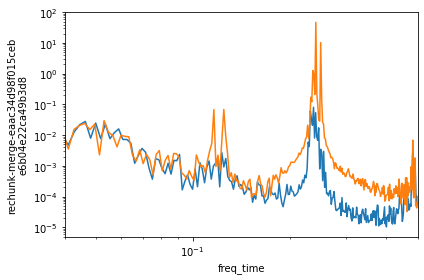

In [20]:
filtered_ps[292:,920:-920,850:-850].mean(['i','j']).plot()
unfiltered_ps[292:,920:-920,850:-850].mean(['i','j']).plot()
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.04,0.5)

plt.tight_layout()
fig=plt.gcf()
fig.savefig('remove_s2_n2_m2.png')

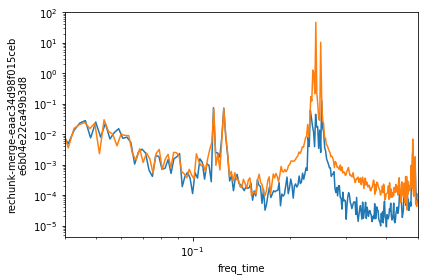

In [37]:
filtered_ps[292:,920:-920,850:-850].mean(['i','j']).plot()
unfiltered_ps[292:,920:-920,850:-850].mean(['i','j']).plot()
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.04,0.5)

plt.tight_layout()
fig=plt.gcf()
fig.savefig('remove_s2_n2_m2.png')

# Now try with full timeseries (not 3hrly)

In [132]:
eta_timechunks = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_detrend.zarr")

In [133]:
eta_28detrend = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_28detrend.zarr")

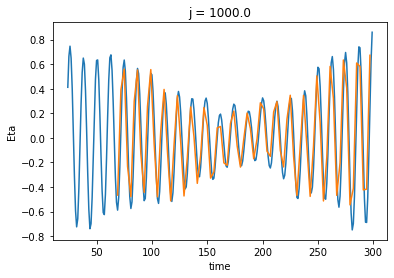

In [145]:
eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(0,300)).plot()
eta_28detrend.Eta.isel(i=1000,j=1000).assign_coords({'time':eta_28detrend.time*3}).isel(time=slice(0,100)).plot()

In [146]:
new_object=xr.DataArray(np.arange(0, 1752),dims=['time'])
new_object = new_object*xr.ones_like(eta_timechunks.Eta)
new_object = new_object.assign_coords({'time':new_object.time*3})

In [159]:
m2=12.4206012/3
s2=12/3
n2=12.65834751/3
k2=11.96723606/3
k1=23.93447213/3
o1=25.81933871/3
q1=26.868350/3
p1=24.06588766/3
#o1 is still really hard to fit in many locations. p1 too and it's very small. I have also stopped fitting k2 because it's too close to s2

def sinusoid_3(time, a=0.004,b=0.5,c=1.3,d=0.1,e=4,f=0.1,g=0.1,h=0.1,k=0.1,l=0.1,m=0.1,n=0.1,o=0.1):#,p=0.1,q=0.1,r=0.1,s=0.1):#):#,h=0.1,k=0.1,r=0.1,s=0.1):
    return (a+b*np.sin(time*2*np.pi/m2+c/3)+d*np.sin(time*2*np.pi/s2+e/3)+f*np.sin(time*2*np.pi/k1+g/3)+h*np.sin(time*2*np.pi/o1+k/3)
       + l*np.sin(time*2*np.pi/n2+m/3)+n*np.sin(time*2*np.pi/k2+o/3))#+p*np.sin(time*2*np.pi/q1+q))#+r*np.sin(time*2*np.pi/p1+s))

In [160]:
new_object.time

<xarray.DataArray 'time' (time: 1752)>
array([   0,    3,    6, ..., 5247, 5250, 5253])
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) int64 0 3 6 9 12 15 18 ... 5238 5241 5244 5247 5250 5253

In [161]:
tide_est = xr.apply_ufunc(sinusoid_3,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d'),
              coeffs.curvefit_coefficients.sel(param='e'),coeffs.curvefit_coefficients.sel(param='f'),
              coeffs.curvefit_coefficients.sel(param='g'),coeffs.curvefit_coefficients.sel(param='h'),
              coeffs.curvefit_coefficients.sel(param='k'),
                          coeffs.curvefit_coefficients.sel(param='l'),
              coeffs.curvefit_coefficients.sel(param='m'),coeffs.curvefit_coefficients.sel(param='n'),
                        coeffs.curvefit_coefficients.sel(param='o'),#check_it.curvefit_coefficients.sel(param='p'),
                      #  check_it.curvefit_coefficients.sel(param='q'),check_it.curvefit_coefficients.sel(param='r'),
                      #  check_it.curvefit_coefficients.sel(param='s')
            dask='allowed')

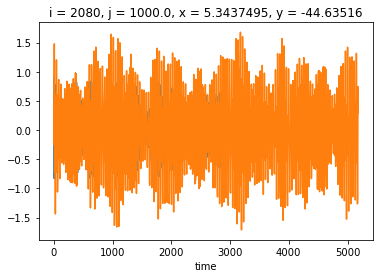

In [162]:
tide_est.isel(i=1000,j=1000,time=slice(1,1000)).plot()
(eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(24,2000))-tide_est.isel(i=1000,j=1000,time=slice(0,-24))).plot()

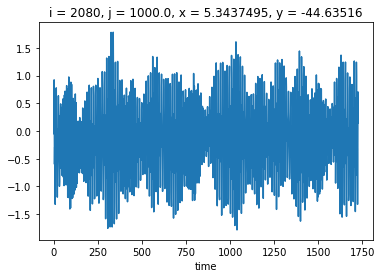

In [107]:
(eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(25,2000)).drop_vars('time')-tide_est.isel(i=1000,j=1000,time=slice(1,-23)).drop_vars('time')).plot()

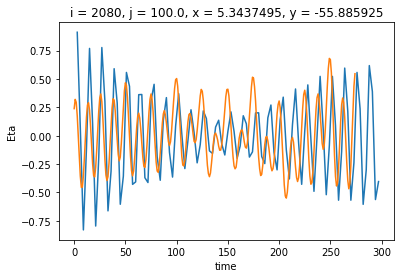

In [164]:
tide_est.isel(i=1000,j=1000,time=slice(1,100)).plot()
(eta_timechunks.Eta.isel(i=1000,j=100,time=slice(25,300))).plot()

In [98]:
eta_timechunks.time

<xarray.DataArray 'time' (time: 1752)>
array([           'NaT',  259200000000000,  262800000000000, ...,
       6552000000000000, 6555600000000000, 6559200000000000],
      dtype='timedelta64[ns]')
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] NaT 3 days 00:00:00 ... 75 days 22:00:00
Attributes:
    axis:           T
    calendar:       gregorian
    long_name:      Time
    standard_name:  time

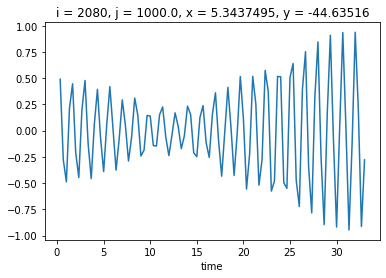

In [90]:
tide_est.isel(i=1000,j=1000,time=slice(1,100)).plot()

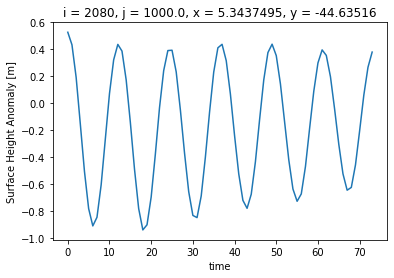

In [89]:
eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(26,100)).drop_vars('time').plot()

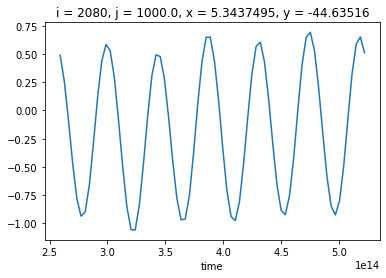

In [62]:


(eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(26,100)).drop_vars('time')-tide_est.isel(i=1000,j=1000,time=slice(1,100-25))).plot()

In [40]:
eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(25,1000)).drop_vars('time')

<xarray.DataArray 'Eta' (time: 975)>
dask.array<getitem, shape=(975,), dtype=float32, chunksize=(975,), chunktype=numpy.ndarray>
Coordinates:
    i        int64 2080
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    j        float64 1e+03
    x        float32 dask.array<chunksize=(), meta=np.ndarray>
    y        float32 dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: time
Attributes:
    long_name:      Surface Height Anomaly
    standard_name:  ETAN
    units:          m